# Final assignment of “Management and Analysis of Physics Datasets”- Part 2

#### Gerardo Carmona
#### Hilario Capettini
#### Saverio Monaco

## Fun Exercise  
You might have seen this kind of puzzles on social media. It should be straight-forward for you to understand which operations connect the two numbers  before the '=' sign. What is the result of the $\boldsymbol{?}$ field? Show proof for each line!

$$\begin{align*}& 1 + 2 = 3 \\ & 2 + 5 = 7 \\ & 3 + 7 = 4 \\ & 4 + 5 = \space\boldsymbol{?} \\ & 5 + 9 = 12\end{align*}$$

### SOLUTION
If we rewrite the digits as binary, we can easily guess the actual operation:
$$
\begin{align}
1 + 2 &= 3&&: &&f(01,10)&& &&=11\\
2 + 5 &= 7&&: &&f(010,101)&& &&=111\\
3 + 7 &= 4&&: &&f(011,111)&& &&=100\\
4 + 5 &=\ ?&&: &&f(100,101)&& &&=\ ?\\
5 + 9 &= 12&&: &&f(0101,1001)&& &&=1100
\end{align}
$$

For all expression, we can replace $f(a,b)$ with $a\oplus b$, thus obtaining $100\oplus 101 = 001 = 1$ for "$4+5$".

## 1 Redundancy
We  are  programming  a  file  based  RAID-4  software  algorithm.  For  this purpose  we  are  converting  a  single  input  (**raid4.input**)  file  into  four  data files ```raid4.0,raid4.1,raid4.2,raid4.3 ```   and  one  parity  file  ```raid4.4``` -  the four data and one parity file we call ‘stripe files’. 

The input file can be downloaded from: 
http://apeters.web.cern.ch/apeters/pd2021/raid4.input

To do this we are reading in a loop sequentially blocks of four bytes from the input file until the whole file is read:
* in  each  loop  we  write  one  of  the  four  read  bytes  round-robin  to  each  data  file, compute  the  parity  of  the  four  input  bytes  and  write  the  result  into  the  fifth parity file.  ( see the drawing for better understanding ) 

* we continue until all input data has been read. If the last bytes read from the input file  are  not  filling  four  bytes,  we  consider  the  missing  bytes  as  zero  for  the  parity computation.

#### Input File (horizontal)
**raid4.input - total size 170619 bytes**<br>
(number in cell = byte offset in file)

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | ... | ... | 170618 | 
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

#### Output File (vertical)
(number in cell = byte offset in file, p0,1,2... are the row-wise parities)

| raid4.0 | raid4.1 | raid4.2 | raid4.3 | raid4.4 |
|---|---|---|---|---|
| 0 | 1 | 2 | 3 | p0 |
| 4 | 5 | 6 | 7 | p1 |
| 8 | 9 | 10 | 11 | p2 |
| 12 | 13 | 14 | 15 | p3 |
| ... | ... | ... | ... | ... |

#### Stripe parity
(column wise parity)

| q0=0^4^8^12 | q1 | q2 | q3 | q4 |
|---|---|---|---|---|

In [1]:
import numpy as np

def get_arr(path):
    '''Reads a file as bytes'''
    with open(path,'r+b') as file:
        v = np.frombuffer(file.read(),dtype = np.uint8)
    return v


def post_arr(arr, path):
    '''Writes an array to a file, converting it to bytes'''
    with open(path,'w+b') as file:
        file.write(arr.tobytes())
    return


def xor_arr(matrix):
    '''Applies the bitwise xor function to a collection of arrays, given as rows in a matrix.'''
    # Neutral xor array
    v = np.zeros(len(matrix[0]),dtype = np.uint8)
    # Applying bitwise_xor between the matrix rows
    for arr in matrix:
        v = np.bitwise_xor(v,arr)
    return v



### 1.1 Write a program (C,C++, R or Python), which produces four striped data and one parity file as described above using the given input file. 
**hint:** if you have a problem programming this yourself, you can download the core program in C++ from http://apeters.web.cern.ch/apeters/pd2021/raid4.cSee the explanations in the beginning how to compile and run it. You have to add the parity computations at the IMPLEMENT THIS sections! If you can’t compile or run it, you can still fill in the missing implementation! 

In [2]:
n = 4
src_file = 'raid4.input'
all_bytes = get_arr(src_file)
all_bytes

# We calculate how many zeros have to be added in the end
extra = n - len(all_bytes)%n
bytes_arr = np.hstack([all_bytes,np.zeros(extra, dtype = np.uint8)])

# Reshaping array
nrows = len(bytes_arr)//n
ncols = n
bytes_arr = bytes_arr.reshape((nrows,ncols))
## Rendered as unsigned integers of 8 bits.
bytes_arr


array([[ 37,  80,  68,  70],
       [ 45,  49,  46,  51],
       [ 10,  37, 196, 229],
       ...,
       [ 55,  55,  51,  55],
       [ 10,  37,  37,  69],
       [ 79,  70,  10,   0]], dtype=uint8)

In [3]:
# Iterate over the columns and generate the files
for i, v in enumerate(bytes_arr.T):
    post_arr(v, f'raid{n}.{i}')

# Evaluating parity between stripes
row_p = xor_arr(bytes_arr.T)

#Store the row parity
post_arr(row_p,f'raid{n}.{n}')

In [4]:
## Unsigned 8bit integer representation of the parity stripe
row_p.T

array([119,   1,  14, ...,   4,  79,   3], dtype=uint8)

### 1.2 Extend the program to compute additionally the parity of all bytes within one stripe file. 
You can say, that the computed column-wise parity acts as a *corruption check*  for each stripe file. Compute the size overhead by comparing the size of all 5 stripe files with the original file.  The size overhead is ________ % !

In [5]:
# We end up with five files with the same number of bytes, which is simply the length of the arrays.
overhead = len(row_p)*5/len(all_bytes)-1
overhead *= 100
print(f'The size overhead is {round(overhead,2)}%')

The size overhead is 25.0%


In [6]:
# We now wish to generate an extra file with the parity of each column
ext_bytes = np.vstack((bytes_arr.T, row_p)).T

# Evaluating parity for each stripe
col_p = xor_arr(ext_bytes)

# Store the resulting parity
post_arr(col_p,f'raid{n}.col')

### 1.3 What is the 5-byte parity value if you write it it in hexadecimal format like $P^5$  =0x[q0][q1][q2][q3][q4], where the [qx] are the hexadecimal parity bytes computed by xor-ing all bytes in each stripe file.  
A byte in hexadecimal has two digits and you should add leading 0 if necessary.<br> 
Examples:
* a byte with contents 1 in hexadecimal is 0x01. A byte with contents 255in hexadecimal is 0xff.
* a possible 5-byte parity would be P5 = 0 x 01 0c 1a 2f 3e

In [7]:
# Casting as strings the hexadecimal representation of each byte and setting to a convenient format.
p_5 = [str(i.tobytes()).split('x')[1][:-1] for i in col_p]
p_5 = '0x'+'_'.join(p_5)
print(f'The 5-parity in hex format is {p_5}')

The 5-parity in hex format is 0xa5_07_a0_9c_9e


### 1.4 If you create a sixth stripe file, which contains the row-wise parities of the five stripe files, what would be the contents of this file? 

Write down the equation for R, which is the XOR between all data stripes D0,D1,D2,D3 and the parity P. Remember P was the parity of D0,D1,D2,D3! Reduce the equation removing P from it to get the answer about the contents! 

### SOLUTION
$$
\begin{align}
R &= D_0\oplus D_1\oplus D_2\oplus D_3\oplus P\\
&= P\oplus P\\
&= \mathbf{0}
\end{align}
$$
since $a\oplus b$ evaluates to $0$ when $a$ and $b$ have the same value, which is of course the case for every row in the expression above.

### 1.5 After some time you recompute the 5-byte parity value as in 1.3. Now the result is $P^5$ = 0x a5 07 a0 01 9e. Something has been corrupted. You want to reconstruct the original file raid4.input using the 5 stripe files.
Describe how you can recreate the original data file. Which stripe files do you use and how do you recreate the original data file with the correct size? 

In [8]:
def correct(col_parity, new_col_parity, file_key):
    # Both col_p and new_col_p are expected as bytes objects
    col_p = np.frombuffer(bytes(col_parity),dtype = np.uint8)
    new_p = np.frombuffer(new_col_parity,dtype = np.uint8)
    mask = col_p != new_p

    # How many parity values have changed?
    wrong = np.arange(len(col_p))[mask]
    right = np.arange(len(col_p))[~mask]
    
    # We cannot correct if more than one stripe is damaged or no stripe damage was detected.
    if len(wrong) != 1:
        message = 'More than one stripe has corrupted elements. Nothing can be done.'\
            if wrong else 'Nothing to correct.'
        print(message)
        return None    

    # If only one stripe is damaged then we can proceed to bit correction.
    # Retrieve as an array of row vectors those stripes to be evaluated
    w = np.vstack([get_arr(f'{file_key}.{i}') for i in right])
    v = xor_arr(w)
    
    # Time to correct
    [j] = wrong
    path = f'{file_key}.{j}'
    post_arr(v,path)
    print(f'Successfully rewrote {path}')
    
    return v


In [9]:
p_5 = 0xa5_07_a0_01_9e.to_bytes(5,'big')
p_5

b'\xa5\x07\xa0\x01\x9e'

In [10]:
correct(bytes(col_p),p_5,'raid4')

Successfully rewrote raid4.3


array([ 70,  51, 229, ...,  55,  69,   0], dtype=uint8)

## 2 Cryptography
The Caesar cipher is named for Julius Caesar, who used an alphabet where decrypting would shift three letters to the left. A friend has emailed you the following text: K]amua!trgpy. She told you that her encryption algorithm works similar to the Caesar cipher:
* to  each ASCI  value  of  each  letter  I  add  a  secret keyvalue.  (note that ASCII values range from 0 to 255) 
* additionally  to  make  it  more  secure  I  add  a  variable  (so  called) noncevalue to each ASCII number.

The nonce start value is 5 for the first character of the message. For each following character add 1 to the nonce of the previous character, e.g. for the second letter the nonce added is 6, for the third letter it is 7 aso. 

### 2.1 Is this symmetric or asymmetric encryption and explain why?

Since no private key has been created this encryption method is symmetric also The sender does not need the public key of the receiver and in order to decript it.

### 2.2 Write a small brute force program which tests keys from 0..255 and use a dictionary approach to figure out the original message. 
In Python you can use the ord() function to get an integer representation of a character and the chr() to retrieve a character string from an integer!

In [11]:
#!pip install pyenchant
import re, string, enchant
d = enchant.Dict("en_US")

In [12]:
'''This function will be used in the decrypt method'''
# If the ASCII character is over 255, it will bring it back between 0 and 255 cycling it
# for example if ord(letter) = 260 it will be transformed to 4
# (assuming the range being from 0 to 255)
def reshift(letter,ascimin,ascimax):
    if ord(letter) < ascimin:
        return chr(ord(letter) - ascimin + ascimax + 1)
    elif ord(letter) > ascimax:
        return chr(-ascimax + ord(letter) + ascimin - 1)
    else:
        return letter

'''Decryption function'''
def decrypt(mex,nonce0,shift,ascimin,ascimax):
    word = []
    nonce = nonce0 # the starting value of the nonce value
    
    for letter in mex:
        # Since we are decrypting and not encrypting, nonce must be negative
        shiftedchr = chr(ord(letter) - nonce + shift)
        
        # Here we are eventually correcting the ASCII number if it is higher ascimax or lower than ascimin
        # because of the shifting
        correctedshiftedchr = reshift(reshift(shiftedchr,ascimin,ascimax),ascimin,ascimax)
        word.append(correctedshiftedchr)
        nonce = nonce + 1 #  for each letter nonce grows by 1
        
    return word

'''Setting the descypted proposals'''
# Sicne we need to check if the words belong to an English dictionary, we need to preprocess
# the result of decrypt function, we make everything lowercase, split the words whenever we find a space
# character and removing every puntuation character
def stringtowords(phrase):    
    clear_word = ''
    for char in phrase:
        if char not in string.punctuation:
            clear_word += char
    return clear_word.lower().split()
    

In [13]:
ascimax = 255
ascimin = 0
mex = 'K]amua!trgpy'
nonce0 = 5

for i in range(ascimin,ascimax):
    decrypted = decrypt(mex,nonce0,i,ascimin,ascimax)
    words = stringtowords(decrypted)
    for word in words:
        # In the dictionary valid words are single digits numbers and letters, this avoids getting those
        # samples
        if len(word) != 1:
            # Some special non-printable characters break the function d.check()
            try:
                d.check(word)
                if d.check(word) == True:
                    print(i,':',' '.join(words))
            except:
                pass

10 : padova rocks
246 : mpbm ow


What is the decryption algorithm/formula to be used?

The used key is <font color='royalblue'>10</font> , the original message text is <font color='royalblue'>Padova rocks<font> ! 

## 3 Object Storage
In an object storage system we are mapping objects by name to locations using a hash table.  Imagine we have a system with ten hard disks (10 locations). We enumerate the location of a file using an index of the hard disk [0..9].

<img src="https://i.ibb.co/dPLWgCs/Screenshot-at-2021-06-02-20-43-04.png" width="800" height="600"/>

Our hash algorithm for placement produces hashes, which are distributed uniform over the value space for a flat input key distribution.  

We want now to simulate the behaviour of our hash algorithmwithout the need to actually compute any hash value.

Instead  of  using  real  filenames,  which  we  would  hash  and  map  using  a hash  table  to  a  location  (as  we  did  in  the  exercise),  we  are  ‘computing’  a location for ‘any’ file by generating a random number for the location in  the  range  [0..9]  to  assign  a  file  location.  To  place  a  file  in  the  storage system  we  use  this  random  location  where  the  file  will  be  stored  and consumes space. 

Assume each disk has 1TB of space, we have 10TB in total.

Place as many files of 10GB size as possible to hard disks choosing random locations until one hard disk is full. <br> **Hint:** a hard disk is full once you have stored hundred 10GB files.

### 3.1Write a program in Python, R or using ROOT, which simulates the placement of 10GB files to random locations and account the used space on each hard disk. Once the first hard disk is full, you stop to place files.

Remark: the distribution changes every time if the random generator is not seeded always with the same start value. Nevertheless both ways are accepted! 

Possibly visualise the distribution similar to the histogram above.

In [14]:
#!pip install psutil
import psutil
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
np.random.seed(1234)
choice = np.random.choice

# Assuming np.int64 arrays, 
# this is the maximum array size allowed for the system
n_available = psutil.virtual_memory().available//8

# The simulation function is a bit more elaborate than a file-by-file while loop approach.
# Although the latter is more straightforward, it proved to be too slow for the calculations performed in 3.4.
# This approach exploits numpy and numba for speed purposes.
@njit(fastmath = True)
def place_files(N_disks, disk_size, file_size, cores_running = 1):
    # Initially available space (translated to files)
    eff_size = disk_size//file_size
    max_new_files = np.repeat(eff_size,N_disks)

    while np.all(max_new_files > 0):
        # At least how many more files have to be placed to fill one of the hard disks?
        min_max_files = max_new_files.min()
 
        # On average, how many placements would have to be made for this to be reached?
        avg_new_files = (3*N_disks//4)*min_max_files

        # Generate an array for random placement of that many files
        placings = choice(np.arange(N_disks),min(n_available//cores_running,avg_new_files))# For memory reasons, there's an upper bound to the number of new files.

        ## Count how many files will be added to each disk
        new_files, _ = np.histogram(placings,bins = np.arange(N_disks+1))

        # did we miss?
        excess = new_files - max_new_files
        while np.any(excess > 0):
            # by at least how many files?
            ex = excess[excess>0].sum()
            pl_ex = placings[-ex:]
            placings = placings[:-ex]
            ## Count how many files will be removed from each disk
            rem_files, _ = np.histogram(pl_ex,bins = np.arange(N_disks+1))
            new_files -= rem_files
            excess = new_files - max_new_files
        
        # is more than one disk full? Stepping back element by element.
        while (excess>=0).sum() > 1:
            rem_in = placings[-1]
            placings = placings[:-1]
            new_files[rem_in] -= 1
            excess = new_files - max_new_files


        # How much space is left now?
        max_new_files -= new_files

    free_space = max_new_files*file_size
    return free_space


def plot_usage(disk_size,free_space):
    N_disks = len(free_space)
    used = [(disk_size - f)/1024 for f in free_space]
    plt.bar(range(N_disks),used, width = 0.98, tick_label = range(N_disks), color = 'gray')
    plt.title('Used space on each disk')
    plt.xlabel('harddisk')
    plt.ylabel('Used [GB]')
    plt.show()



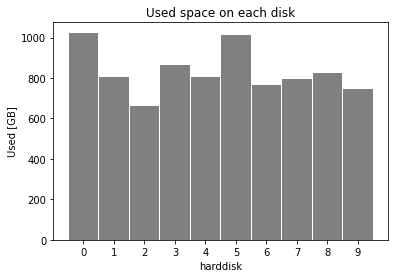

In [15]:
N_disks = 10; disk_size = 1024*1024 # ten 1TB = 1048576MB disks
file_size = 10*1024 # 10GB files

free_space = place_files(N_disks,disk_size,file_size)
free_space
placed_files = (N_disks*disk_size-free_space.sum())//file_size

plot_usage(disk_size,free_space)

### 3.1a How many files did you manage to place?

In [16]:
print(f'{placed_files} files were successfully placed.')

830 files were successfully placed.


### 3.1b What is the percentage of total used space on all hard disks in the moment the first disk is full?

In [17]:
total_space = N_disks*disk_size
used_percentage = 100*(total_space-sum(free_space))/total_space
print(f'{round(used_percentage,2)}% of the total available space was used.')

81.05% of the total available space was used.


### 3.2 Repeat the same task placing 1GB files until the first hard disk is full.

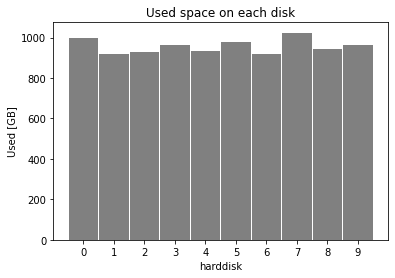

In [18]:
file_size = 1024 # 1GB files

free_space = place_files(N_disks,disk_size,file_size)

placed_files = (N_disks*disk_size-free_space.sum())//file_size

plot_usage(disk_size,free_space)

### 3.2a How many files did you manage to place?

In [19]:
print(f'{placed_files} files were successfully placed.')

9567 files were successfully placed.


### 3.2b What is the percentage of total used space on all hard disks in the moment the first disk is full? 

In [20]:
total_space = N_disks*disk_size
used_percentage = 100*(total_space-sum(free_space))/total_space
print(f'{round(used_percentage,2)}% of the total available space was used.')

93.43% of the total available space was used.


### 3.3 Based on this observation: why do you think object storage typically stores fixed size blocks of 4M and not files of GBs size as a whole? (so called block storage approach) 

Run the same program for 4M block sizes and demonstrate the benefits

### SOLUTION
To begin with, as the file size is smaller, a bigger fraction of the fullest disk can be used before stopping.
Let each disk have the same probability of being selected for storage. Since, when using smaller blocks, the number $N$ of files is greater for a given size. As $N$ increases, a more evenly distributed placement of files is expected, therefore being able to use a larger fraction of the total space before having to stop.

2617825 files were successfully placed.
99.86% of the total available space was used.


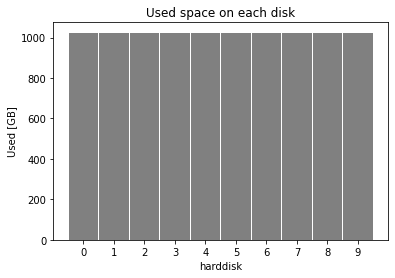

In [21]:
file_size = 4 # 4MB files

free_space = place_files(N_disks,disk_size,file_size)

placed_files = (N_disks*disk_size-free_space.sum())//file_size

print(f'{placed_files} files were successfully placed.')
total_space = N_disks*disk_size
used_percentage = 100*(total_space-sum(free_space))/total_space
print(f'{round(used_percentage,2)}% of the total available space was used.')
plot_usage(disk_size,free_space)

### 3.4. Compute the average used space on all hard disks and the standard deviation for the average used space for 10 GB and 1GB and 4M files. How is the standard deviation correlated to the block size and why?  If we now repeat such an experiment for many more (thousands) of hard disks, which kind of distribution do you get when you do a histogram of the used space of all hard disks?

In [ ]:
# Using dask for simulation time purposes
import dask as dk
from scipy.stats import nbinom

avgs = []
stds = []
sizes = [4,256,512,1024,2*1024,5*1024,10*1024]
pltsizes = [4,1024,10*1024]
N_disks = 10
cores_running = psutil.cpu_count()

for file_size in sizes:
    simulate = lambda N: dk.delayed()(
        [
            dk.delayed(place_files)(N_disks,disk_size,file_size, cores_running = cores_running).sum()\
            for _ in range(N)
        ]
        ).compute()
    sims = np.array(simulate(2500))
    used = (N_disks*disk_size - sims)/1024/1024

    avg = np.average(used)
    std = np.std(used)
    
    avgs.append(avg)
    stds.append(std)

plt.scatter(sizes,avgs)

In [ ]:
##Repeating experiment but with thousands of disks
sizes = [4,1024,10*1024]
N_disks = 2500
results = []

for file_size in sizes:
    simulate = lambda N: dk.delayed()(
        [
            dk.delayed(place_files)(N_disks,disk_size,file_size, cores_running = cores_running).sum()\
            for _ in range(N)
        ]
        ).compute()
    sims = np.array(simulate(500))
    used = (N_disks*disk_size - sims)/1024/1024
    results.append(used)


#plt.hist(used, density=True)
#unit = 'GB' if file_size >= 1024 else 'MB'
#norm = 1 if unit == 'MB' else 1024
#plt.title(f'Final storage use for {int(file_size/norm)}{unit} files')
#plt.xlabel('used space [TB]')
#plt.ylabel('density')
#plt.show()


In [ ]:
lb, ub = int(used.min()*1024*1024/file_size), int(used.max()*1024*1024/file_size)
s = np.arange(lb,1.1*ub)
goal = int(disk_size/file_size)
rv = nbinom(goal,1/N_disks)
p = rv.pmf(s)
a, _ = np.histogram(used, bins = 20)
k = 1/p.max()
plt.plot(s*file_size/1024/1024,k*p)
plt.hist(used, bins = 20, density = True)
plt.show()

Error: Session cannot generate requests

## 4 Rest APIs & Block Chain Technology 

Under https://pansophy.app:8443 you find a Crypto Coin Server exporting a simple Block Chain.

You can open this URL in any web browser to see the current Block Chain status and the account information. At the time of writing the initial birth account of the Block Chain contained 1M coins ( “genesis” : 1000000 ) : 

<img src="https://i.ibb.co/nPNksZt/Screenshot-at-2021-06-02-21-01-56.png" width="800" height="600"/>

The REST responses are given in JSON format. Our REST API uses secure HTTP protocol and it is based on two HTTP methods:

GET

POST 

GET requests are used, to retrieve any kind of information, POST requests are used to change state in the server. 

The task is to implement a client and use a simple REST API to submit transactions to the Block Chain. Your goal is to book coins from other people’s accounts to your own account.  The server implements a Proof Of Time algorithm. To add a transaction to move coins to your account, you have to submit a merit request and you have to let time pass before you can send a claim request to execute your transaction on the Block Chain. If you claim your transaction too fast after a merit request, your request is discarded. The server enforces a Proof Of Time of a minimum of 10 seconds!

In [2]:
import os
import json
import time
import numpy as np
import multiprocessing

In [3]:
url     = 'https://pansophy.app:8443/'
ourteam = 'GitPush'

In [4]:
# If the site does not temporarely work, I saved in this file a json example:
exfile = 'jsonex'

with open(exfile, 'r') as file:
    src = file.read().replace('\n', '')
data = json.loads(src)

In [5]:
'''This function is just auxiliary for other functions. It returns the json of the page'''
# url: the page: https://pansophy.app:8443/
# sec: for how long do you want to read it
# debug: prints the json string
def rest_curl(url,sec = 5, verbose = False, debug = False):
    cmd =  'curl -k ' + url + ' & sleep ' + str(sec) + ' ; kill $!'
    
    if verbose:
        print('Executing:\n  ',cmd)
    scr = os.popen(cmd).read()
    
    if debug:
        print(scr)
    
    if len(scr) == 0:
        print('ERROR: The site is currently NOT working')
        return 0
    else:
        return json.loads(scr)

In [6]:
'''Returns the current situation regarding teams and their coins'''
# offline: if the site does not work set offline=True to load a json example
def rest_teamsandcoins(url, offline = False):
    if offline:
        jsn = data
    else:
        jsn = rest_curl(url, sec = 1, verbose = False)
    
    return(jsn['accounts'])
    
teams = rest_teamsandcoins(url)

#print(teams.keys())   # Prints the teams
#print(teams.values()) # Prints the values

# To convert to an array you can do:
## names = list(teams.keys())
## coins = list(teams.values())

## print(names[0], coins[0])

In [7]:
def rest_initiatetransation(url, team, stealfrom, howmuch = 100):
    cmd = 'curl -k -X POST -H "Content-Type: application/json" -d \'{"operation": "merit","team": "'+ team +'", "coin": '+str(howmuch)+', "stealfrom": "' + stealfrom +'"}\' ' + url
    #print(cmd)
    os.system(cmd)
    return
 
def rest_claimtransation(url, team):
    cmd = 'curl -k -X POST -H "Content-Type: application/json" -d \'{"operation": "claim","team": "'+team+'"}\' ' + url
    #print(cmd)
    os.system(cmd)
    
def rest_initiateandclaim(url, ourteam, enemyteam, howmuch = 100):
    rest_initiatetransation(url, ourteam, enemyteam, howmuch)
    time.sleep(10)
    
    rest_claimtransation(url,ourteam)
    rest_claimtransation(url,enemyteam)

### 4.1.1 Use the REST API  and the curl command to transfer coins of the genesis or any other account on your own team account. 
You can use the -d option to POST a document. You have to indicate in your request, that the content type of the document is JSON. To do this you can add an HTTP header for this command  
```curl ... -H”Content-Type: application/json” ...```

If you prefer, you can use a Python program, doing the same HTTPS requests respecting Proof of Time.If you want to have some more fun, you can also load the current state into your Python script using GET requests and programatically steal from accounts which are reported. Be aware, that you can never steal the last coin of an account and if at the time of a claim there are not enough coins left on an account, your transaction is discarded.

To you will have to add at least one successful transaction to the Block Chain. 

In [8]:
# Here I wanted to use the teamandcoins function to show the balance of coind before and after initiatetransation and claimtransation
# however the site does not currently work

teams = rest_teamsandcoins(url)
names = list(teams.keys())
coins = list(teams.values())

print('Balance before transfer:')
print('  ',names[names.index(ourteam)],': ',coins[names.index(ourteam)])

rest_initiatetransation(url, ourteam, 'FaoTom', 100)
time.sleep(10)
rest_claimtransation(url,ourteam)

teams = rest_teamsandcoins(url)
names = list(teams.keys())
coins = list(teams.values())

print('\nBalance after tansaction')
print('  ',names[names.index(ourteam)],': ',coins[names.index(ourteam)])

Balance before transfer:
   GitPush :  15400

Balance after tansaction
   GitPush :  15500


### 4.1.2 What is the maximum number of transactions one given team can add to the Block Chain in one day? 

To find the maximum number of transaction we tried different methods:

In [9]:
'''BRUTEFORCE'''
# this method just makes a transaction every 10 seconds and updates a counter
bruteforce = False
i = 0

while(bruteforce):
    rest_initiatetransation(url, ourteam, 'genesis')
    time.sleep(10)
    rest_claimtransation(url,ourteam)
    
    teams = rest_teamsandcoins(url)
    names = list(teams.keys())
    coins = list(teams.values())

    print(i,':',names[names.index(ourteam)],': ',coins[names.index(ourteam)])
    i = i + 1

The bruteforce method is that straightforward, eventually we would expect some error to show up but until now it didn't, the amount of transactions appears to be only limited by the **Proof Of Time** rule:
$$\text{Maximum number of transactions} = \frac{\text{# seconds in a day}}{10}=\frac{24*3600}{10} = 8640$$

Two methods were tried in order to bypass this limit, however they ended up being unsuccessful. (See Appendix)

### 4.2 The server has a function to compute a hash of a block in the Block Chain: 
<img src="https://i.ibb.co/Lnr32nS/Screenshot-at-2021-06-02-21-01-28.png" width="800" height="600"/>

In [2]:
import hashlib

def calculate_hash(index,team,prev_hash,coins,timestamp):
    block_of_string = "{}{}{}{}{}".format(index,
                                          team,
                                          prev_hash,
                                          coins,
                                          timestamp)
    #print(block_of_string)
    return hashlib.sha256(block_of_string.encode()).hexdigest()

calculate_hash(2250,'GitPush',"d30ac7cf770b3db510ae388fc84160534c805d93c681c5dcbb8b1c8933e87525",301,1623770741)

'bbed9bfd59dbb2bd92c5d82797c827dd6a646bf0a69795eddc76bc0796958c04'

### 4.2.1 Explain what this function does and why is this ‘the key’ for Block Chain technology? 

Given an instance, the function ```calculate_hash``` creates the next hash in the chain. Each block of the blockchain contains the hashstring for the previous block and for itself. This will let us navigate in the blockchain through this reference method.

Most importantly the hash is used for decorruption and security purposes (as explained later)

### 4.2.2 If you have the knowledge of the hash function, how can you validate the contents of the Block Chain you received using a GET request to make sure, nobody has tampered with it? You don’t need to implement it! Explain the algorithm to validate a Block Chain!

Being the hash generated using the contents as an input, we can generate the hash from the block and see if it maches the hash we already have.

### 4.2.3 Why might the GET REST API run into scalability problems? 
Express the scalability behaviour of execution times of GET and POST requests in Big O notation in relation to the number of transactions recorded in the Block Chain! Draw execution time vs transactions for GET and POST requests. 

POST just appends text in json format in the document, it does not depend on how many transactions were made, it scales as O(1)\
GET reads the whole document, the bigger the file is the longer it will take, it scales as O(n)

### 4.2.4 If the Crypto server goes down, the way it is implemented it loses the current account balances. How can the server recompute the account balances after a restart from the saved Block Chain? 

It should compute the balances after every transaction from the Genesis block to the latest one. Possibly checking if the hashes are correct (Integrity check).\
This of course not optimal if the number of all transactions is very high.

### 4.2.5 What are the advantages of using a REST API and JSON in a client-server architecture? What are possible disadvantages? 

A client-server architecture is relatively easy to implement and fast, however it lacks of proper secury. A more common choice is a peer-to-peer architecture that is more secure being decentalized, however it faces some complexity of syncronization between all nodes (solved by sophisticated algorithms).

# Appendix

## 4
The following two methods are attemps to by-pass the **Proof Of Time** 10-seconds block:
* Using multiprocess it was tested if multiple transaction could be made by spawning different terminal shells so that the maximum number of transaction would be higher and dependent on the number of available accounts too, however the error: ``{"msg": "accepted"}{"msg": "claim too early - deleted your request"}`` appeared anyway.

* The **Proof Of Time** block must then be linked to the accounts who steals, then a way to parallelize the instances would be simply require to make instances from the other accounts of a negative-value amount. This way each parallelized instance is made from a different account. Sadly the error ``{"msg": "negative or zero values are forbidden"}`` showed up, telling us we can make a transacion of negative or zero values

In [ ]:
'''TRYING TO PARALLELIZE IT USING MULTIPROCESSING'''
# this method finds the available accounts we can steal from an use the multiprocess library to 
# steal from them in parallel
multi = False
i = 0

while (multi):
    teams = rest_teamsandcoins(url)
    names = np.array(list(teams.keys()))
    coins = np.array(list(teams.values()))
    print(i,':',names[np.where(names == ourteam)],': ',coins[np.where(names == ourteam)])
    availableteams = np.delete(names[coins > 100],np.where(names[coins > 100] == ourteam))
    for enemy in availableteams:
        p1 = multiprocessing.Process(target=rest_initiatetransation,args=(url,ourteam,enemy))
        p1.start()
    
    time.sleep(10)
    p1.join()
    p1.terminate()
    p1.close()
    rest_claimtransation(url,ourteam)
    i = i + 1

'''NEGATIVE THEFT IDEA'''
# this method instead of stealing a certain amount from accounts, makes in parallel instances from all the
# available accounts to ours of a negative amount
negamulti = False
i = 0

while(negamulti):
    teams = rest_teamsandcoins(url)
    names = np.array(list(teams.keys()))
    coins = np.array(list(teams.values()))
    print(i,':',names[np.where(names == ourteam)],': ',coins[np.where(names == ourteam)])
    availableteams = np.delete(names[coins > 100],np.where(names[coins > 100] == ourteam))
    for enemy in availableteams:
        p1 = multiprocessing.Process(target=rest_initiatetransation,args=(url,enemy,ourteam,-100,))
        p1.start()
    p1.join()
    p1.terminate()
    p1.close()
    i = i + 1
    for enemy in availableteams:
        rest_claimtransation(url,enemy)
        rest_claimtransation(url,ourteam)